# Computer Vision Assignment
In this assignment you will be required to create a CV classifier on the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. To achieve this you will be required to create and compare different classifier. More precisely you will be asked to:

*   Create the right data-loading pipeline (e.g., Data augmentation, batch size, loading strategy, etc.)
*   Select the proper transfer learning strategy (e.g., fine-tuning, transfer learning, training from scratch) 
*   Select the right hyperparameters (e.g., learning rate, optimizer)

More importantly, you are required to **explain** the choices that you make. To do so, you can also perform different experiments (e.g., comparing two different learning rates or transfer learning strategies) and provide a comment on why one perform better than the other at the end of the notebook. 
You can re-use the notebook that we have been using in the classroom.

You are only provided with:


*   The dataset (directly provided by Torchvision)
*   The neural architecture: a Resnet18 `network = torchvision.models.resnet18()`






### Evaluation of the assignment

The evaluation of the assignment will be based on 3 different aspects:

- Percentage of assignment completed (50 % of the grade)
- Correctness of the comments used to explain the result (40% of the grade)
- Validation accuracy of the final model provided (10 % of the grade)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import copy
from assignment_utils import *
%reload_ext autoreload
%autoreload 2

cudnn.benchmark = True
plt.ion()   # interactive mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device", device)

Device cuda:0


## Loading Data

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify ten different objects: _airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck_. We have 50000 training images and 10000 validation images.

We can directly load the dataset from its torchvision class.

Now we have to create the dataloader, as we in the previous lab for the logistic regression. Notice however that we are using one more parameter:

- `num_workers` is used to _parallelize_ the loading from disk.

Indeed, image datasets are too big normally to fit in memory and images are loaded from disk at every batch. In this case we do that using 4 threads to load the 16 images in parallel (4 per thread).

---

## Data transformations

### An overview of transformations performed

When loading data, we perform data augmentation. This allows to increase the dataset size by:

- Performing `RandomResizedCrop`, which is defined as follows by PyTorch:\
  \
  _The `RandomResizedCrop` transform crops an image at a random location, and then resizes the crop to a given size._

  Illustration:

  ![img](https://pytorch.org/vision/main/_images/sphx_glr_plot_transforms_013.png)

- Performing a horizontal flip with a given probability. Our images should still be classifiable even if they are horizontally flipped, this is not always acceptable depending on the problem.

  ![img](https://pytorch.org/vision/main/_images/sphx_glr_plot_transforms_024.png)

- Convert to tensor (this is a type formality, not very interesting in terms of data augmentation)
- Normalizing (center & scale) the images to prevent scale differences

On the validation set, we don't apply a `RandomResizedCrop`, but a `CenterCrop`, which doesn't perform the resize. This keeps the image sharper and may facilitate classification. Compare the following illustration with the one of `RandomResizedCrop`:

![img](https://pytorch.org/vision/main/_images/sphx_glr_plot_transforms_003.png)

By cropping towards the center, we also try not to remove part of the object to be classified (that may lay on the side of the image). This may be acceptable in the training set so that the algorithm learns to classify from a part of the object, but we don't want the algorithm to report low accuracy because a data augmentation technique removed too much of the object from the image.\
Furthermore, [some sources](https://stackoverflow.com/a/61637688/11680331) indicate that random transformations are only allowed on the training set (_i.e._ not on the validation set), as they should be undoable.

### Data Normalization

On another note and according to [some sources](https://stats.stackexchange.com/a/220970/311789), data normalization allows to keep the magnitude of the gradients in check. This permits a more stable training.

### Batch size

[Some sources](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/) recommend batch sizes of 32, 64, 128 or 256. I personally started with smaller batch sizes that were allowed by my GPU. Indeed, larger batch sizes, produced an error stating that there was not enough memory available. I started testing with batches of size 4, 8 or 16. It turns out that my GPU allows up to 32. I chose to keep 32 because it is as far as I can go and it is part of the recommendations above.\
The normalization values should come from the training set only in order to avoid data leakage. In our case, the values were obtained from [this](https://github.com/kuangliu/pytorch-cifar/issues/19) website.


In [2]:
data = Data(dl_num_workers=5, dl_batch_size=32, use_subset=True, subset_n_samples=2048)
pred = Prediction()

Files already downloaded and verified
Files already downloaded and verified
Train size:     50000
Val size:       10000
Class names:    airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck


### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



In [3]:
data.imshow_train_val(num_img=4)

## Select and compare different transfer - learning strategy

You need to compare the 3 learning strategy and comment the results obtained:

- Transfer Learning (remember to directly extract the features!)
- Fine tuning
- Training from scratch

Start simple! Traning from scratch may be very expensive with this dataset since we have 50000 images.

Also, to ensure that your code is working, you can use `torch.data.Subset(dataset, indexes)` to use a smaller version of the dataset


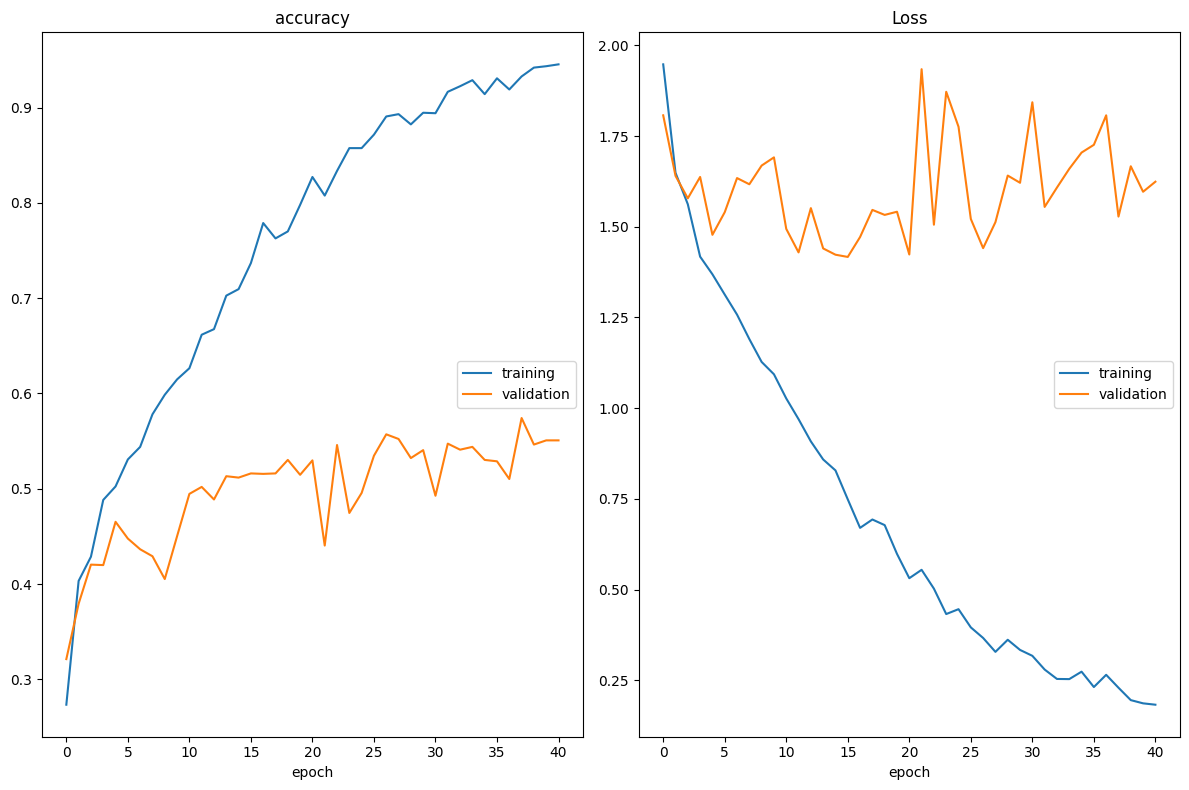

accuracy
	training         	 (min:    0.273, max:    0.945, cur:    0.945)
	validation       	 (min:    0.321, max:    0.574, cur:    0.551)
Loss
	training         	 (min:    0.183, max:    1.948, cur:    0.183)
	validation       	 (min:    1.417, max:    1.934, cur:    1.624)
Max training time reached (2700), breaking.
Training complete in 45m 5s
Best val Acc: 0.574219


In [4]:
lr = 1e-4
weight_decay = 1e-4

# Model
model = torchvision.models.resnet18(num_classes=NUM_CLASSES).to(DEVICE)

# Loss
loss = F.cross_entropy

# Optimizer
opt = optim.AdamW(params=model.parameters(), lr=lr, weight_decay=weight_decay)

# Function
model = pred.train_model(
  model=model,
  train_dl=data.train_dl,
  val_dl=data.val_dl,
  loss=loss,
  optim=opt,
  num_epochs=2000,
  max_train_time=60 * 45,
)


### ResNet18 as a feature extractor

We use `resnet18` as a feature extractor. That is, we use all layers except the last one, which we replace by a virgin, untouched linear layer to perform the classification. Let us give some more details on the feature extraction part, then on the classification part.

##### Feature extraction

The $n-1$ layers perform feature extraction. Indeed, they identify properties of the image that can be used to perform classification. These properties can be edges, pixels around which a lot of contrast happens, parts of an object (ears, paws, nose, ...etc.). In the end, this is what the network needs to make its classification. The actual difficult part is to understand these features, then the classification part ``only" consists in mapping those extracting features to what makes up a ship, a plane, a frog, ...etc.

##### Classification

Using a custom, brand new linear layer at the end allows various things. First, as mentioned, the linear layer performs the mapping from the extracted features to the classes in our dataset. Furthermore, it allows to use custom classes, that is, not the ones on which the `resnet18` algorithm has been trained. Finally, using a new, custom linear layer also allows to specify the number of output features (_i.e._ the number of prediction classes, since this is the last layer). Indeed, in our case there are 10 target classes, whereas the bees vs ants problem we did during a lecture had 2 classes, and different problems have different number of classes.


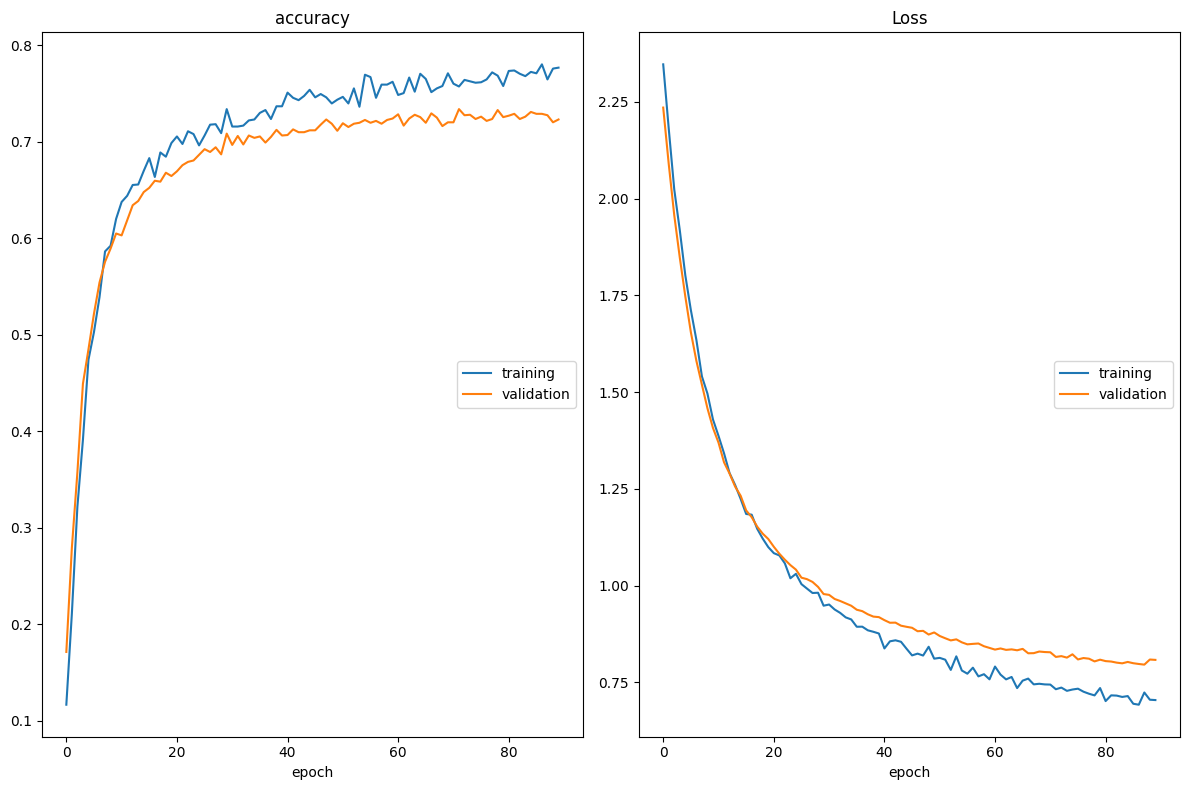

accuracy
	training         	 (min:    0.117, max:    0.780, cur:    0.777)
	validation       	 (min:    0.171, max:    0.734, cur:    0.723)
Loss
	training         	 (min:    0.693, max:    2.347, cur:    0.705)
	validation       	 (min:    0.796, max:    2.235, cur:    0.808)
Max training time reached (2700), breaking.
Training complete in 45m 12s
Best val Acc: 0.733887


In [5]:
lr = 1e-4

# Model
model_fe = torchvision.models.resnet18(
  weights=torchvision.models.ResNet18_Weights,
).to(DEVICE)

# Freeze all layers but last
model_fe.requires_grad_(False)
model_fe.fc = nn.Linear(in_features=model_fe.fc.in_features, out_features=NUM_CLASSES)

# Loss
loss = F.cross_entropy

# Optimizer
opt = optim.AdamW(params=model_fe.fc.parameters(), lr=lr)

# Function
model_fe = pred.train_model(
  model=model_fe,
  train_dl=data.train_dl,
  val_dl=data.val_dl,
  loss=loss,
  optim=opt,
  num_epochs=2000,
  max_train_time=60 * 45,
)


In [3]:
# Extract the training dataset
trainset_extr = pred.extract_features(data.train_dl)
train_dl_extr = DataLoader(trainset_extr, batch_size=16, shuffle=True)

# Extract the validation dataset
valset_extr = pred.extract_features(data.val_dl)
val_dl_extr = DataLoader(trainset_extr, batch_size=16)

/home/joris/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cpu
cpu


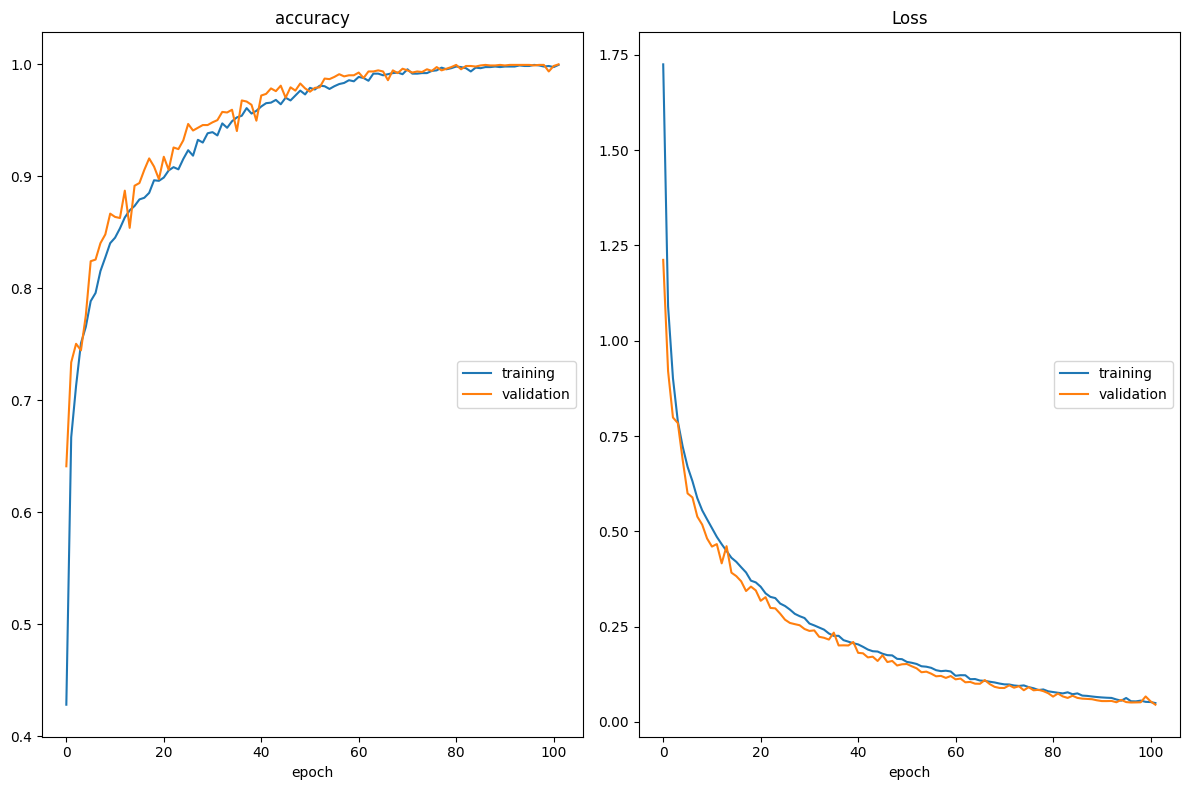

accuracy
	training         	 (min:    0.428, max:    1.000, cur:    1.000)
	validation       	 (min:    0.641, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.050, max:    1.725, cur:    0.050)
	validation       	 (min:    0.045, max:    1.212, cur:    0.045)
Training complete in 1m 11s
Best val Acc: 1.000000


In [5]:
lr = 0.001

# Model
model_fe = torchvision.models.resnet18(
  weights=torchvision.models.ResNet18_Weights,
).to(DEVICE)
model_fe2 = nn.Linear(in_features=model_fe.fc.in_features, out_features=NUM_CLASSES)

# Loss
loss = F.cross_entropy

# Optimizer
opt = optim.Adam(params=model_fe2.parameters(), lr=lr)

# Function
model_fe2 = pred.train_model(
  model=model_fe2,
  train_dl=train_dl_extr,
  val_dl=val_dl_extr,
  loss=loss,
  optim=opt,
  num_epochs=102,
  max_train_time=60 * 10,
)


#### A note on data augmentation

The curves plotted above when training FS (From Scratch) and when FT (Fine-Tuning) show that the training accuracy is **higher** than the validation accuracy. This is normally what happens, but it is interesting to note that our data augmentation techniques do not seem to be too brutal. Indeed, when they are too brutal, the training accuracy takes a hit and can even go below the validation accuracy. Thus we validate the values we used in the data augmentation process.

When comparing to the TL (Transfer Learning) strategy however, we see that the training and the validation accuracy curves get close to each other, with a slight trend of the validation accuracy curve being higher that the training counterpart. This means that our data augmentation techniques are really close to being too brutal. In this case however, since the validation accuracy is about equal to the training accuracy, we consider that we don't need to go back and change the values in the transforms. With a more significant difference however, we would have needed to go back and reduce significance of the data augmentation strategies, that is, less cropping, less resizing and potentially less horizontal flip (although the latter probably doesn't bother the network too much).

### Comparison of techniques

We obtain the following results from training:

| Technique         | Training time | Epochs | Dataset size | Training Accuracy | Val Accuracy | Training Loss | Val Loss |
| ----------------- | ------------- | ------ | ------------ | ----------------- | ------------ | ------------- | -------- |
| From scratch      | 45 min        | 42     | 2048         | 0.945             | 0.574        | 0.183         | 1.417    |
| Fine tuning       | 45 min        | 90     | 2048         | 0.782             | 0.734        | 0.693         | 0.786    |
| Transfer Learning | 1 min         | 102    | 2048         | 1.000             | 1.000        | 0.050         | 0.045    |

From the table above, we note that for the same training time, FT performs about twice as many epochs as FS. This means that FT sees about twice as many images compared to FS in the same time. However, both of these network perform very far from TL, which simply improves the weights for the last linear (classification) layer, which drastically reduces the number of values to be propagated backwards throughout the network.

Because we used a small subset (2048 samples), in order to speed up the process, the TL network is able to obtain an accuracy of 1.000 on both training and validation, which would likely not happen with the full dataset. We are reassured in thinking that this is not a sign of an underlying coding error on my side because the loss still isn't 0.000 and the curves don't show anything too alarming.

## Select and compare hyperparameters

Once you found the best transfer learning strategy, I want you to find the best hyperparameters:

- Learning Rate
- Data augmentation
- Optional: optimizer, batch size, etc.

### A note about hyperparameters

Although we discussed the choise of batch size and the transformations making the data augmentation part, we didn't explore the learning rate or the optimizer. There are a couple of reasons for that:

- First, running experiments on the learning rate requires to let the network train for several tens of epochs, which takes a long time, especially for the FS setting. I was running out of time to hand in the assignment and could not afford 5-10 30+ minutes experiments (early family Christmas celebrations). The expected strategy and conclusion are the following: start with a learning rate of 1e-4, then increase in powers of 10 until the network doesn't converge anymore. Then pick up one of the learning rates that make the network converge as quickly as possible, but without losing convergence. I also included weight decay in my optimizer, which may allow for larger learning rates initially since the learning rate is decreased over epochs.
- Second, running experiments on the optimizer is also fairly costy and Adam tends to win most of the time. It would have been interesting to compare Adam to AdamW, which is especially good for neural networks, according to Prof. CIRAVEGNA, but I haven't tested it myself yet.
